## Results
This notebook finds all the results of the paper.

#### Config

In [1]:
## load some packages
# estimation
from scipy.stats import gaussian_kde
from toolkit.estimation import (
        estimation_G,  # matrix
        log_beta, log_inv_gamma,  # priors
        gen_posterior_prob, get_invhessian,  # number things
        posterior_mode, metropolis_hastings,  # estimation
    )

# model
from models.hank import HANK
from toolkit.irfs import *

# general
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## config
# plt.style.use('seaborn-v0_8-dark-palette')
plt.rcParams.update({
        'text.usetex': True,
        'font.family': 'serif',
    })

#### Solve the Model
Given our parameterization, solve the model for the steady state and perturbation matricies.

In [2]:
## intialize model
mod_pars = {
        'gamma': 4., 'chi': 2.,  # household parameters, beta and phi are chosen in calibration
        'N_z': 7, 'rho_z': 0.963, 'sigma_z': 0.134,  # household state transitions
        'kappa': 0.1,  # philips curve
        'rho_B': 0.95, 'omega_pi': 1.5, 'omega_Y': 0.,  # govt parameters
        'A': 1., 'psi': 1.2, 'g': 0.201, 'xi': 1., 'tauP': 1.18, 'eta': 0.081,  # shock steady states
        'pi': 1., 'B': 0.577,  # variable steady states we define (otherwise model can't be solved)
        'I': 1.005, 'Y': 1.,  # varaible steady states we target
        'N_a': 501, 'a_min': 0, 'a_max': 50,  # grid states
    }
hank = HANK(**mod_pars)

## solve steady state
free = ['beta', 'phi']
endog = ['R', 'G', 'tauL', 'N', 'M', 'D', 'curlN', 'curlC', 'curlB']
markets = {m: HANK.markets[m] for m in ['mkt3', 'mkt4']}  # the other markets clear by definition or by an analytic form
V_a0 = (hank.a_grid[:, None] * (hank.I - 1) + hank.z_grid)**(-hank.gamma)
X0 = np.array([0.97, 2.5])
hank.solve_ss(free, endog, V_a0, X0, markets=markets)
assert np.isclose(hank.curlC + hank.G - hank.Y, 0)  # walras

## solve for perturbation matrix
T = 300
G, dxs = hank.solve_G(T, ha=True, h=1e-4)

f'phi = {hank.phi}; beta = {hank.beta}'

'phi = 2.5491621758196934; beta = 0.9654434908711715'

#### Read the Data
Once we read the data, we multiply it by our steady state values. That's because 

In [3]:
# ## read data, creates in make_data.ipynb
# df = pd.read_csv('data/data.csv')

# # make it levels of model values
# df['Y'] *= hank.Y
# df['C'] *= hank.curlC
# df['B'] *= hank.B
# df['W'] *= hank.W
# df['N'] *= hank.N

#### Estimation
For the estimation, I first find the posterior mode and the inverse Hessian at that points. Then, I use MCMC to trace the posterior distribution.

In [4]:
# ## Setup
# outputs = np.array(['Y', 'pi', 'I', 'N', 'curlC', 'B'])  # outputs we estimate off of
# est_outputs = np.where(outputs == 'curlC', 'C', outputs)  # rename 'curlC' to align with data df
# priors = (
#         [lambda x: log_beta(x, 0.5, 0.15) for _ in range(6)]  # ar1 coeffs
#         + [lambda x: log_inv_gamma(x, 0.4, 4) for _ in range(6)]  # standard deviations
#     )
# est_G = estimation_G(G, outputs=outputs)  # make the G matric used in estimation, just concatenated version of G
# drawf = gen_posterior_prob(est_G, df[np.where(outputs == 'curlC', 'C', outputs)].values, priors)  # evaluate log-liklihood

# ## posterior mode
# res = posterior_mode(drawf, 6, X0=np.hstack((0.5 * np.ones(6), 0.1 * np.ones(6))), tol=0.001)
# assert res.success
# mode = res.x  # get the mode values
# invH = get_invhessian(drawf, mode)  # used to make draws in MCMC

In [5]:
# ## MCMC
# bounds = np.array([(0, 1) for _ in range(6)] + [(0, np.inf) for _ in range(6)]).T
# N_sim = 2500  # takes ~3 min per 10k
# N_burn = 500
# np.random.seed(0)
# sim_res, logposterior, accept_rate = metropolis_hastings(drawf, mode, invH, bounds, N_sim, N_burn)
# print(f'Accept Rate: {accept_rate * 100:.2f}%')

# ## get results
# means = np.mean(sim_res[N_burn:], axis=0)  # mean
# conf_int = np.percentile(sim_res[N_burn:], [5, 95], axis=0)  # confidence interval

# ## collect results
# res_df = pd.DataFrame(
#         data=np.vstack((mode, means, conf_int)).T[[0, 6, 1, 7, 2, 8, 3, 9, 4, 10, 5, 11]],
#         columns=['mode', 'mean', '5%', '95%'],
#         index=np.ravel([(f'rho_{s}', f'sigma_{s}') for s in hank.shocks]),
#     )
# # res_df.to_csv('data/bayes_results.csv')
# res_df

In [6]:
# ## iteration trace plot
# # setup plot
# fig, axs = plt.subplots(4, 3, sharex=True)
# fig.set_figwidth(6.5)
# fig.set_figheight(7)
# fig.supxlabel('Draw', y=1/20 * 8/7)
# fig.supylabel('Parameter Value')

# # plot them all
# shock_labels = ['A', r'\psi', 'g', r'\xi', r'{\tau^P}', r'\eta']
# for i in range(6):
#     # plot rho
#     ax = axs[2 * (i // 3), i % 3]
#     ax.set_title(rf'$\rho_{shock_labels[i]}$')
#     recursive_mean = sim_res[:, i].cumsum() / np.arange(1, 1 + sim_res.shape[0])
#     ax.plot(recursive_mean, 'k-', linewidth=0.5)

#     # plot sigma
#     ax = axs[2 * (i // 3) + 1, i % 3]
#     ax.set_title(rf'$\sigma_{shock_labels[i]}$')
#     recursive_mean = sim_res[:, 6 + i].cumsum() / np.arange(1, 1 + sim_res.shape[0])
#     tln, = ax.plot(recursive_mean, 'k-', linewidth=0.5, label='Recursive Mean')

# ## make the figure
# fig.tight_layout(pad=0.75)
# fig.subplots_adjust(bottom=1/10 * 8/7)
# fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0), frameon=False, handles=[tln], ncols=2)
# # fig.savefig('paper/figures/recursive_means.pdf')

In [7]:
# ## posteriors plot
# # setup plot
# fig, axs = plt.subplots(4, 3)
# fig.set_figwidth(6.5)
# fig.set_figheight(8)
# fig.supxlabel('Parameter Value', y=1/20)
# fig.supylabel('Density')

# # plot them all
# shock_labels = ['A', r'\psi', 'g', r'\xi', r'{\tau^P}', r'\eta']
# maxs = sim_res.max(axis=0)
# mins = sim_res.min(axis=0)
# for i in range(6):
#     # plot rho
#     ax = axs[2 * (i // 3), i % 3]
#     ax.set_title(rf'$\rho_{shock_labels[i]}$')
#     kde = gaussian_kde(sim_res[:, i])
#     x = np.linspace(mins[i], maxs[i], 250)
#     ax.plot(x, kde(x), c='k')

#     # means
#     ax.axvline(means[i], linestyle='--', color='gray')

#     # plot sigma
#     ax = axs[2 * (i // 3) + 1, i % 3]
#     ax.set_title(rf'$\sigma_{shock_labels[i]}$')
#     kde = gaussian_kde(sim_res[:, 6 + i])
#     x = np.linspace(mins[6 + i], maxs[6 + i], 250)
#     dln, = ax.plot(x, kde(x), c='k', label='Density')

#     # means
#     mln = ax.axvline(means[6 + i], linestyle='--', color='gray', label='Mean')

# ## make the figure
# fig.tight_layout(pad=0.75)
# fig.subplots_adjust(bottom=1/10)
# fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0), frameon=False, handles=[dln, mln], ncols=2)
# # fig.savefig('paper/figures/posteriors.pdf')

In [8]:
# ## triangle plot
# # setup plot
# fig, axs = plt.subplots(2 * 6, 2 * 6, sharex='col')
# fig.set_figheight(6.5)
# fig.set_figwidth(6.5)
# for ax in axs[np.triu_indices(2 * 6, k=1)]:
#     ax.set_axis_off()

# # single variable things
# labels = [
#         r'$\rho_A$', r'$\sigma_A$', r'$\rho_\psi$', r'$\sigma_\psi$',
#         r'$\rho_g$', r'$\sigma_g$', r'$\rho_\xi$', r'$\sigma_\xi$',
#         r'$\rho_{\tau^P}$', r'$\sigma_{\tau^P}$', r'$\rho_\eta$', r'$\sigma_\eta$']
# order = [0, 6, 1, 7, 2, 8, 3, 9, 4, 10, 5, 11]
# maxs = sim_res.max(axis=0)
# mins = sim_res.min(axis=0)
# for i, s in enumerate(order):
#     # formatting
#     axs[i, i].set_xticks([])
#     axs[i, i].set_yticks([])

#     # density plot
#     kde = gaussian_kde(sim_res[:, s])
#     x = np.linspace(mins[s], maxs[s], 250)
#     axs[i, i].plot(x, kde(x), c='k')

#     # axis labels
#     axs[-1, i].set_xlabel(labels[i])
#     axs[i, 0].set_ylabel(labels[i])

# # two variable things
# for i, s1 in enumerate(order):
#     for j, s2 in enumerate(order[:i]):
#         # formatting
#         axs[i, j].set_xticks([])
#         axs[i, j].set_yticks([])
#         axs[i, j].sharey(axs[i, 0])

#         # density
#         kde = gaussian_kde(sim_res.T[[s2, s1]])
#         x, y = np.meshgrid(np.linspace(mins[s2], maxs[s2], 100), np.linspace(mins[s1], maxs[s1], 100))
#         kdef = np.reshape(kde(np.vstack((x.ravel(), y.ravel()))), x.shape)
#         axs[i, j].contourf(x, y, kdef, cmap='binary')

# # final things
# fig.tight_layout(pad=0.25)
# # fig.savefig('paper/figures/triangle.pdf')

In [9]:
## run instead of estiation, loads from file
res_df = pd.read_csv('data/bayes_results.csv', index_col=0)
shock_pars = res_df['mean'].to_dict()  # save the means to a dictaionary
rhos = {p.split('_')[1]: v for p, v in shock_pars.items() if p.startswith('rho')}
sigmas = {p.split('_')[1]: v for p, v in shock_pars.items() if p.startswith('sigma')}

#### Aggregate IRFs

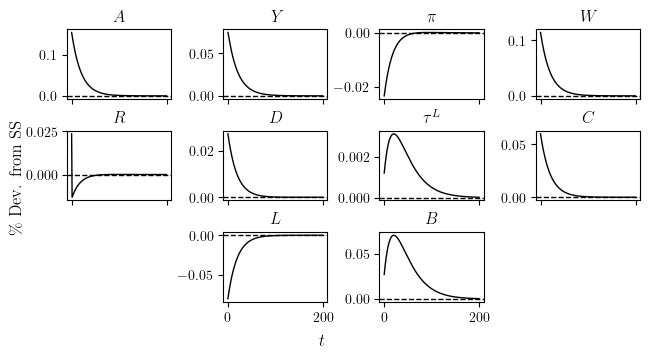

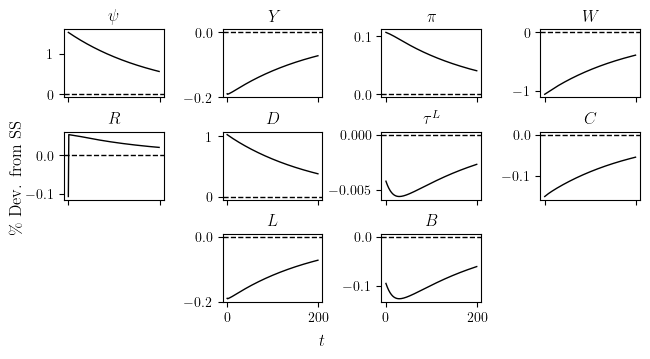

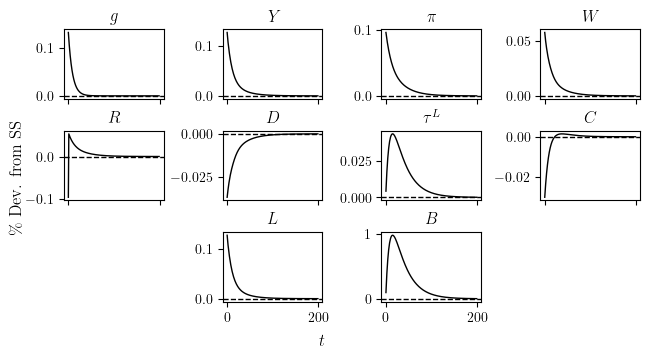

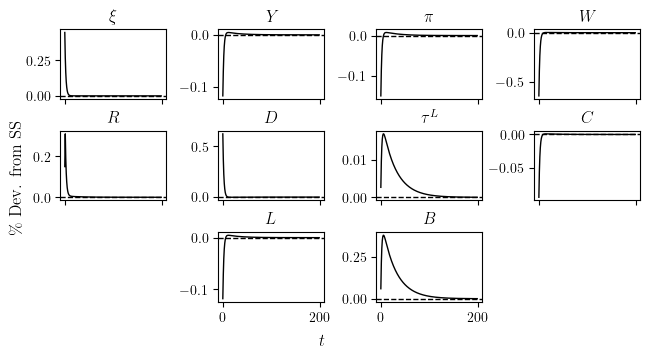

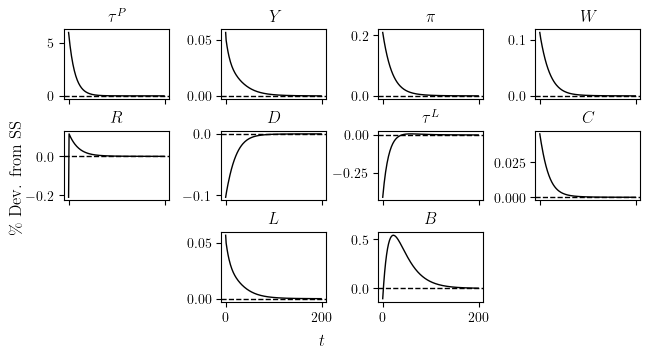

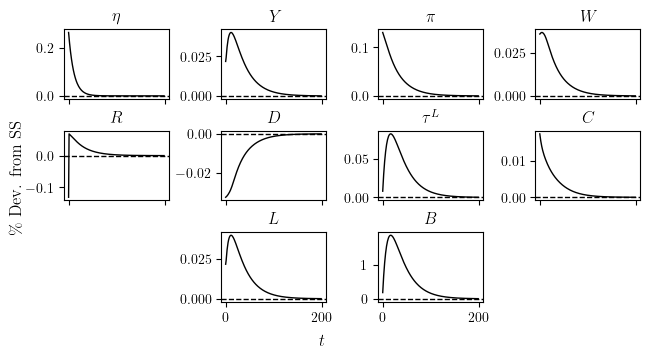

In [10]:
tmax = 200
labels = {   # keys for labeling
        'A': '$A$', 'psi': r'$\psi$', 'g': '$g$', 'xi': r'$\xi$', 'tauP': r'$\tau^P$', 'eta': r'$\eta$',  # shocks
        'pi': r'$\pi$', 'W': '$W$', 'M': '$M$', 'D': '$D$', 'R': '$R$', 'I': '$I$', 'tauL': r'$\tau^L$',  # prices
        'curlC': '$C$', 'curlN': '$L$', 'curlB': '$B$',  # hh aggs
        'Y': '$Y$', 'N': '$N$', 'B': '$B$', 'G': '$G$',  # econ aggs
    }

for Z in hank.shocks:
    # solve irfs
    X_irfs, Z_irf = single_shock_irfs(G[Z], rhos[Z], T, sigma=sigmas[Z])

    # plot setup
    fig, axs = plt.subplots(3, 4, sharex=True)
    fig.set_figwidth(6.5)
    fig.set_figheight(3.5)
    fig.supxlabel('$t$')
    fig.supylabel(r'\% Dev. from SS')
    axs[2, 0].set_axis_off()
    axs[2, 3].set_axis_off()
    axs = np.delete(axs.flatten(), [8, 11])
    outcomes = ['Y', 'pi', 'W', 'R', 'D', 'tauL', 'curlC', 'curlN', 'curlB']

    # plot each irf
    axs[0].set_title(labels[Z])
    axs[0].plot(Z_irf[:tmax], '-k', linewidth=1)
    axs[0].axhline(0, c='k', ls='--', linewidth=1)
    for ax, X in zip(axs[1:], outcomes):
        ax.set_title(labels[X])
        ax.plot(X_irfs[X][:tmax], '-k', linewidth=1)
        ax.axhline(0, c='k', ls='--', linewidth=1)

    # final things
    fig.tight_layout(pad=0.5)
    # fig.savefig(f'paper/figures/{Z}_agg_irf.pgf')

#### Aggregate Variance Decomposition

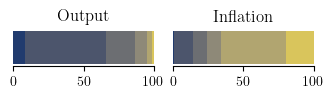

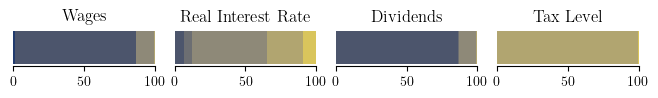

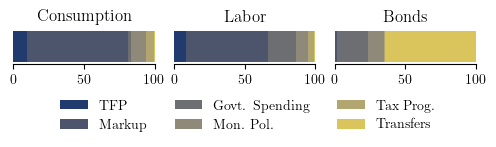

In [11]:
## get variaences
vars = all_shock_variences(all_shock_irfs(G, rhos, T, sigma=sigmas), h=4)
labels = {   # keys for labeling
        'A': 'TFP', 'psi': 'Markup', 'g': 'Govt. Spending', 'xi': 'Mon. Pol.', 'tauP': 'Tax Prog.', 'eta': 'Transfers',  # shocks
        'pi': 'Inflation', 'W': 'Wages', 'M': '$M$', 'D': 'Dividends', 'R': 'Real Interest Rate', 'I': 'Interst Rate', 'tauL': 'Tax Level',  # prices
        'curlC': 'Consumption', 'curlN': 'Labor', 'curlB': 'Bonds',  # hh aggs
        'Y': 'Output', 'N': 'Labor', 'B': 'Bonds', 'G': 'Govt. Spending',  # econ aggs
    }
sns.set_palette(sns.color_palette('cividis'))

def plot_var_decomp(var, ax):
    # format graph
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks([])
    ax.set_xlim(0, 100)

    # varience decompoisiont
    shock_pct = np.array(list(var.values()))
    shock_pct = 100 * shock_pct / shock_pct.sum()
    shock_pct_start = shock_pct.cumsum() - shock_pct
    for i, s in enumerate(var.keys()):
        ax.barh('h', shock_pct[i], left=shock_pct_start[i], label=labels[s])

## make the plots
for outcomes, t in zip([['Y', 'pi'], ['W', 'R', 'D', 'tauL'], ['curlC', 'curlN', 'curlB']], ['agg', 'hh_dec', 'hh_agg']):
    fig, axs = plt.subplots(1, len(outcomes))
    fig.set_figwidth(6.5 / 4 * len(outcomes))
    fig.set_figheight(0.9)
    for i, X in enumerate(outcomes):
        axs[i].set_title(labels[X])
        plot_var_decomp(vars[X], axs[i])
    fig.tight_layout(pad=0.4)
    # fig.savefig('paper/figures/var_decomp_' + t + '.pgf')
fig.set_figheight(1.4)
fig.tight_layout(pad=0.4)
fig.subplots_adjust(bottom=4/7)
fig.legend(*axs[0].get_legend_handles_labels(), ncol=3, loc='lower center', bbox_to_anchor=(0.5, 0), frameon=False)
# fig.savefig('paper/figures/var_decomp_' + t + '.pgf')

#### Household Steady States

In [12]:
## Areas of interest
wealth_percentiles = [0.5, 0.9, 0.99]
income_percentiles = [0.1, 0.5, 0.9]
pts_a = np.searchsorted(hank.dist.sum(axis=1).cumsum(), wealth_percentiles)  # points on the asset grid, 50th, 90th, 99th percentile
pts_z = np.searchsorted(hank.z_dist.cumsum(), income_percentiles)  # points on the productivity grid, 10th, 50th, 90th percentile
hank.z_grid[pts_z], hank.a_grid[pts_a]

# make info
hh_df = pd.DataFrame(
        np.array([
            np.repeat(hank.z_grid[pts_z], 3),
            np.tile(hank.a_grid[pts_a], (3, 1)).ravel(),
            hank.c[pts_a][:, pts_z].T.ravel(),
            hank.l[pts_a][:, pts_z].T.ravel(),
            hank.a[pts_a][:, pts_z].T.ravel(),
        ]).T,
        columns=['z', 'wealth', 'c', 'l', 'a']
    )
hh_df['W'] = hh_df['z'] * hh_df['l'] * hank.W
hh_df['R'] = hh_df['wealth'] * hank.R
hh_df['T'] = hank.D + hank.eta
hh_df['tau'] = hank.tauL * hh_df['z']**hank.tauP
total_income = hh_df['W'] + hh_df['R'] + hh_df['T']
hh_df[['W', 'R', 'T', 'tau']] = hh_df[['W', 'R', 'T', 'tau']].div(total_income.values, axis=0) * 100

hh_df

,z,wealth,c,l,a,W,R,T,tau
0,0.443992,0.00000,0.577771,1.141266,0.000000,63.030845,0.000000,36.969155,13.756234
1,0.443992,1.94313,0.700553,0.776278,1.695020,11.545378,78.499095,9.955527,3.704455
2,0.443992,6.30892,0.819092,0.567850,5.886984,3.090523,93.266373,3.643104,1.355600
3,1.000000,0.00000,0.783533,0.931314,0.000000,75.808168,0.000000,24.191832,23.465278
4,1.000000,1.94313,0.853434,0.785003,1.761020,22.915671,68.408523,8.675806,8.415245
5,1.000000,6.30892,0.938305,0.649417,5.950779,7.590923,88.935156,3.473921,3.369588
6,2.252291,0.00000,1.004273,0.850784,0.214025,86.572768,0.000000,13.427232,33.950043
7,2.252291,1.94313,1.032758,0.804499,2.051515,40.694746,52.630475,6.674779,16.876824
8,2.252291,6.30892,1.086867,0.726390,6.238420,17.146049,79.739234,3.114716,7.875395


#### Household Policy Rules

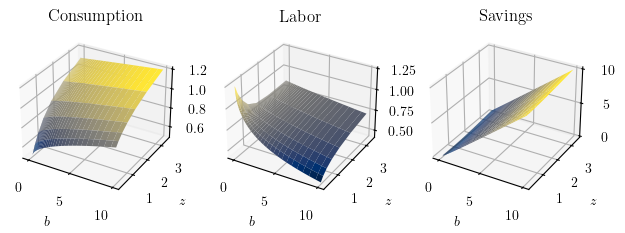

In [13]:
## plot setup
fig, axs = plt.subplots(1, 3, subplot_kw=dict(projection='3d'))
fig.set_figwidth(6.5)
fig.set_figheight(2.5)
for ax in axs:
    ax.set_xlabel('$b$')
    ax.set_ylabel('$z$')

## plot each thing
n = (hank.a_grid <= 10).sum()
axs[0].set_title('Consumption')
axs[0].plot_surface(X=np.tile(hank.a_grid[:n], (hank.N_z, 1)).T, Y=np.tile(hank.z_grid, (n, 1)), Z=hank.c[:n], cmap='cividis')
axs[1].set_title('Labor')
axs[1].plot_surface(X=np.tile(hank.a_grid[:n], (hank.N_z, 1)).T, Y=np.tile(hank.z_grid, (n, 1)), Z=hank.l[:n], cmap='cividis')
axs[2].set_title('Savings')
axs[2].plot_surface(X=np.tile(hank.a_grid[:n], (hank.N_z, 1)).T, Y=np.tile(hank.z_grid, (n, 1)), Z=hank.a[:n], cmap='cividis')

# final things
fig.tight_layout(pad=2.5)
# fig.savefig('paper/figures/policy_rule_surface.pgf')

#### Household Income Determinants

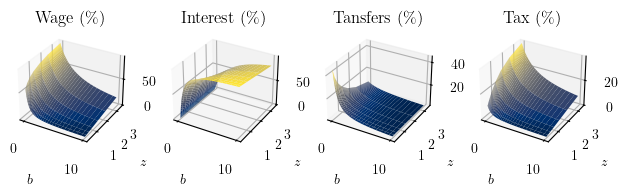

In [14]:
## get elements
n = (hank.a_grid <= 10).sum()
W_pct = hank.z_grid * hank.l[:n] * hank.W
R_pct = (hank.a_grid[:n] * hank.R)[:, None]
T_pct = hank.D + hank.eta
tau_pct = hank.tauL * hank.z_grid**hank.tauP
total = W_pct + R_pct + T_pct
W_pct = 100 * W_pct / total
R_pct = 100 * R_pct / total
T_pct = 100 * T_pct / total
tau_pct = 100 * tau_pct / total

## plot it
fig, axs = plt.subplots(1, 4, subplot_kw=dict(projection='3d'))
fig.set_figwidth(6.5)
fig.set_figheight(2)
for ax in axs:
    ax.set_xlabel('$b$')
    ax.set_ylabel('$z$')

## plot each thing
axs[0].set_title(r'Wage (\%)')
axs[0].plot_surface(X=np.tile(hank.a_grid[:n], (hank.N_z, 1)).T, Y=np.tile(hank.z_grid, (n, 1)), Z=W_pct, cmap='cividis')
axs[1].set_title(r'Interest (\%)')
axs[1].plot_surface(X=np.tile(hank.a_grid[:n], (hank.N_z, 1)).T, Y=np.tile(hank.z_grid, (n, 1)), Z=R_pct, cmap='cividis')
axs[2].set_title(r'Tansfers (\%)')
axs[2].plot_surface(X=np.tile(hank.a_grid[:n], (hank.N_z, 1)).T, Y=np.tile(hank.z_grid, (n, 1)), Z=T_pct, cmap='cividis')
axs[3].set_title(r'Tax (\%)')
axs[3].plot_surface(X=np.tile(hank.a_grid[:n], (hank.N_z, 1)).T, Y=np.tile(hank.z_grid, (n, 1)), Z=tau_pct, cmap='cividis')

# final things
fig.tight_layout(pad=2.5)
# fig.savefig('paper/figures/hh_income_shares.pgf')

#### Decision Rule Variance Decomposition

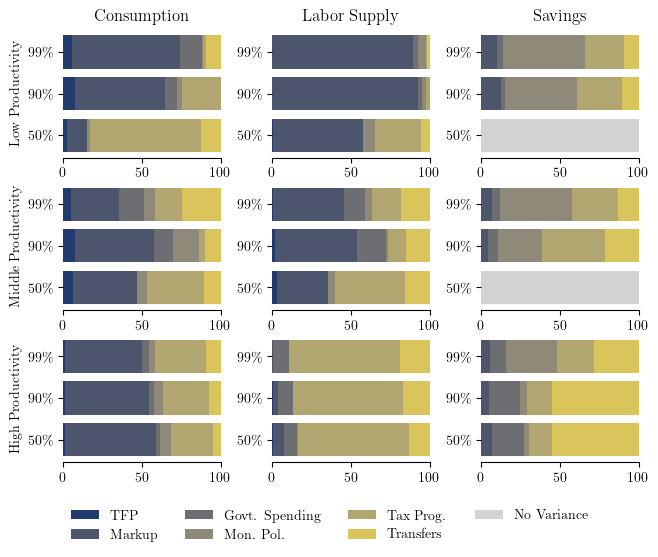

In [15]:
## get variences
vars = all_shock_variences(all_shock_irfs(G, rhos, T, sigma=sigmas, dxs=dxs), h=4)
pts_a = np.searchsorted(hank.dist.sum(axis=1).cumsum(), [0.5, 0.9, 0.99])  # points on the asset grid, 50th, 90th, 99th percentile
pts_z = np.searchsorted(hank.z_dist.cumsum(), [0.1, 0.5, 0.9])  # points on the productivity grid, 10th, 50th, 90th percentile
vars = {x: {Z: var[pts_a][:, pts_z].T for Z, var in vars[x].items()} for x in ['c', 'l', 'a']}
# vars[x][Z][i][j] points to effect of Z on x at income i at asset grid j

## plot formatting
fig, axs = plt.subplots(3, 3)
fig.set_figwidth(6.5)
fig.set_figheight(5.5)
sns.set_palette(sns.color_palette('cividis'))

# titles
axs[0, 0].set_ylabel('Low Productivity')
axs[1, 0].set_ylabel('Middle Productivity')
axs[2, 0].set_ylabel('High Productivity')
axs[0, 0].set_title('Consumption')
axs[0, 1].set_title('Labor Supply')
axs[0, 2].set_title('Savings')

for i, x in enumerate(['c', 'l', 'a']):  # column, variable of interest
    # solve for varience
    var = np.array(list(vars[x].values()))  # get the variences into an array, use array operations to solve for percents
    total = var.sum(axis=0)
    total =  np.where(total != 0, total, 1)
    pct_var = 100 * var / total  # percent
    left_var = pct_var.cumsum(axis=0) - pct_var  # left side of bar

    for j in range(3):  # row, productivity level
        # formatting
        ax = axs[j, i]
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim(0, 100)

        # plot each shock effect
        for k, s in enumerate(hank.shocks):
            ax.barh([r'50\%', r'90\%', r'99\%'], pct_var[k, j], left=left_var[k, j], label=labels[s])
        # gray bar (for no data)
        ax.barh([r'50\%', r'90\%', r'99\%'], 100, left=left_var[5, j] + pct_var[5, j], color='lightgray', label='No Variance')

# final things
fig.tight_layout(pad=0.4)
fig.subplots_adjust(bottom=1/6)
fig.legend(*ax.get_legend_handles_labels(), ncol=4, loc='lower center', bbox_to_anchor=(0.5, 0), frameon=False)
# fig.savefig('paper/figures/policy_var_decomp.pgf')

#### Endogenous Variance Decomposition

In [16]:
## decompose the impulse response function
irf_decomp = decompose_all_irfs(G, hank.int_block_jacs, {Z: ar_shock_irf(rhos[Z], T, sigmas[Z]) for Z in G.keys()}, hank.shocks, dxs=dxs)

## setup
h = 4
pts_a = np.searchsorted(hank.dist.sum(axis=1).cumsum(), [0.5, 0.9, 0.99])  # points on the asset grid, 50th, 90th, 99th percentile
pts_z = np.searchsorted(hank.z_dist.cumsum(), [0.1, 0.5, 0.9])  # points on the productivity grid, 10th, 50th, 90th percentile
def get_var_covs(decomp_arr):
    # solve covs
    covs = (decomp_arr[None, :] * decomp_arr[:, None]).sum(axis=-1)  # get covariences between varibales
    if covs.sum() == 0:
        return np.zeros(covs.shape[0] * (covs.shape[1] + 1) // 2)
    covs = 100 * covs / covs.sum()  # normalize to 100

    # return
    i, j = np.tril_indices(covs.shape[0], -1)
    return np.hstack((np.diag(covs), covs[i, j]))

## lop over variables
for aggx, x in zip(['curlC', 'curlN', 'curlB'], ['c', 'l', 'a']):
    ## decompose irfs
    agg_decomp = {}
    policy_decomp = {}
    keys = {'W': 'W', 'R': 'R', 'D': 'T', 'eta': 'T', 'tauP': r'\tau', 'tauL': r'\tau'}
    for Z, Xirf in irf_decomp.items():
        ## agregates
        for X, irf in Xirf[aggx].items():
            if keys[X] in agg_decomp:
                agg_decomp[keys[X]] += irf[:4]
            else:
                agg_decomp[keys[X]] = 1 * irf[:4]
        
        ## households
        for X, irf in Xirf[x].items():
            if keys[X] in policy_decomp:
                policy_decomp[keys[X]] += irf[:h, pts_a][:, :, pts_z]
            else:
                policy_decomp[keys[X]] = 1 * irf[:h, pts_a][:, :, pts_z]

    ## arrays of decompositions (matrix multiplication is nice)
    agg_decomp_arr = np.array(list(agg_decomp.values()))
    policy_decomp_arr = np.array(list(policy_decomp.values()))

    ## make results dataframe
    factors = np.array(list(agg_decomp.keys()))
    i, j = np.triu_indices(len(factors), 1)
    res_df = pd.DataFrame(data=[np.hstack((factors, factors[i])), np.hstack((factors, factors[j]))], index=['V1', 'V2']).T
    res_df['agg'] = get_var_covs(agg_decomp_arr)
    for i in range(3):
        for j in range(3):
            res_df[f'{i}, {j}'] = get_var_covs(policy_decomp_arr[:, :, j, i])

    ## make the table
    table = r'''\resizebox{\textwidth}{!}{%
\begin{tabular}{lcccccccccc}
    \toprule
    & \textbf{Aggregate} & \multicolumn{3}{c}{\textbf{Low Productivity}} & \multicolumn{3}{c}{\textbf{Middle Productivity}} & \multicolumn{3}{c}{\textbf{High Productivity}} \\
    \cmidrule(lr){3-5} \cmidrule(lr){6-8} \cmidrule(lr){9-11}
    && 50th & 90th & 99th & 50th & 90th & 99th & 50th & 90th & 99th \\
    \midrule
    \textit{Variances} \\
'''
    for i in res_df[res_df['V1'] == res_df['V2']].index:
        table += '    \\quad $\\Var(' + res_df.loc[i, 'V1'] + ')$'
        for v in res_df.values[i, 2:].astype(float):
            table += f' & {v:,.1f}'
        table += ' \\\\\n'
    table += '    \\midrule\n    \\textit{Covariances} \\\\\n'
    for i in res_df[res_df['V1'] != res_df['V2']].index:
        table += '    \\quad $\\Cov(' + res_df.loc[i, 'V1'] + ', ' + res_df.loc[i, 'V2'] + ')$'
        for v in res_df.values[i, 2:].astype(float):
            table += f' & {v:,.1f}'
        table += ' \\\\\n'
    table += '    \\bottomrule \n    \\multicolumn{11}{c}{\\parbox{\\textwidth}{\\vspace{1ex} \\scriptsize \\textit{Notes:} Forecast error variance decomposition calculated at a 4 quarter time horizon with total variance normalized to 100\\%. Percentiles correspond to the 50th, 90th, and 99th wealth percentiles.}}\n\\end{tabular}%\n}'

    print(f'{aggx}, {x}:')
    print(table)

curlC, c:
\resizebox{\textwidth}{!}{%
\begin{tabular}{lcccccccccc}
    \toprule
    & \textbf{Aggregate} & \multicolumn{3}{c}{\textbf{Low Productivity}} & \multicolumn{3}{c}{\textbf{Middle Productivity}} & \multicolumn{3}{c}{\textbf{High Productivity}} \\
    \cmidrule(lr){3-5} \cmidrule(lr){6-8} \cmidrule(lr){9-11}
    && 50th & 90th & 99th & 50th & 90th & 99th & 50th & 90th & 99th \\
    \midrule
    \textit{Variances} \\
    \quad $\Var(W)$ & 1,607.7 & 55.0 & 272.6 & 1,030.4 & 4,382.9 & 156.2 & 106.2 & 30.3 & 27.7 & 28.2 \\
    \quad $\Var(R)$ & 289.5 & 0.0 & 205.6 & 1,151.5 & 0.0 & 174.8 & 166.7 & 42.7 & 48.3 & 52.4 \\
    \quad $\Var(T)$ & 1,707.1 & 164.7 & 1,032.4 & 3,940.4 & 3,884.9 & 198.5 & 158.5 & 14.0 & 14.6 & 17.9 \\
    \quad $\Var(\tau)$ & 33.0 & 21.0 & 69.7 & 109.9 & 190.8 & 2.7 & 0.4 & 2.9 & 2.6 & 2.8 \\
    \midrule
    \textit{Covariances} \\
    \quad $\Cov(W, R)$ & 672.3 & 0.0 & 232.5 & 1,060.9 & 0.0 & 164.1 & 131.8 & 35.9 & 36.4 & 38.3 \\
    \quad $\Cov(W, T)$ & -

In [17]:
## decompose the impulse response function
irf_decomp = decompose_all_irfs(G, hank.int_block_jacs, {Z: ar_shock_irf(rhos[Z], T, sigmas[Z]) for Z in G.keys()}, hank.shocks, dxs=dxs)

In [18]:
irf_decomp['A']['c']['W'][50].shape

(501, 7)

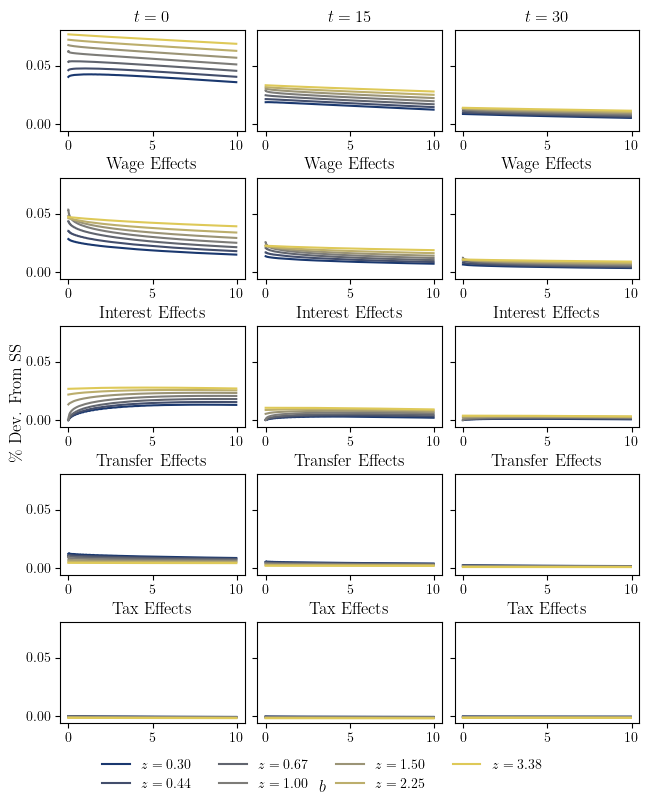

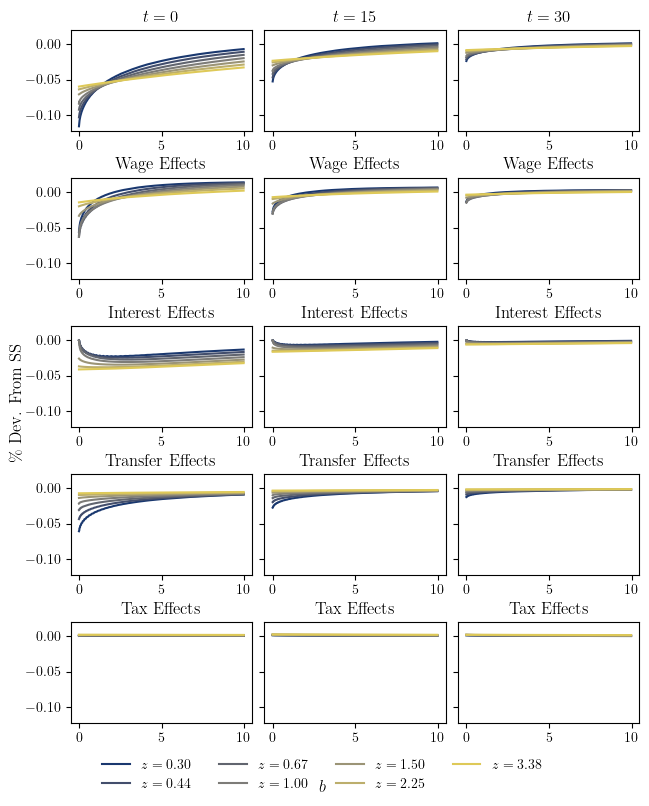

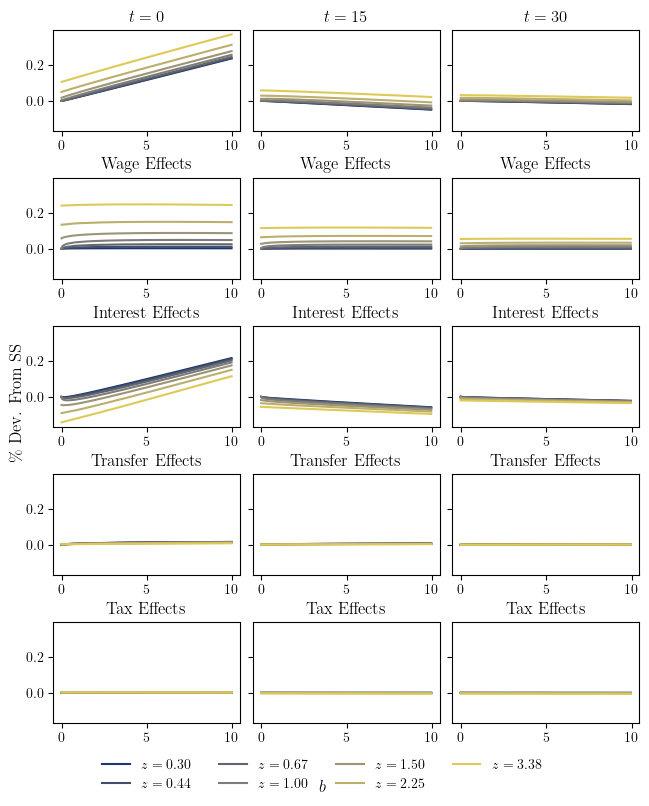

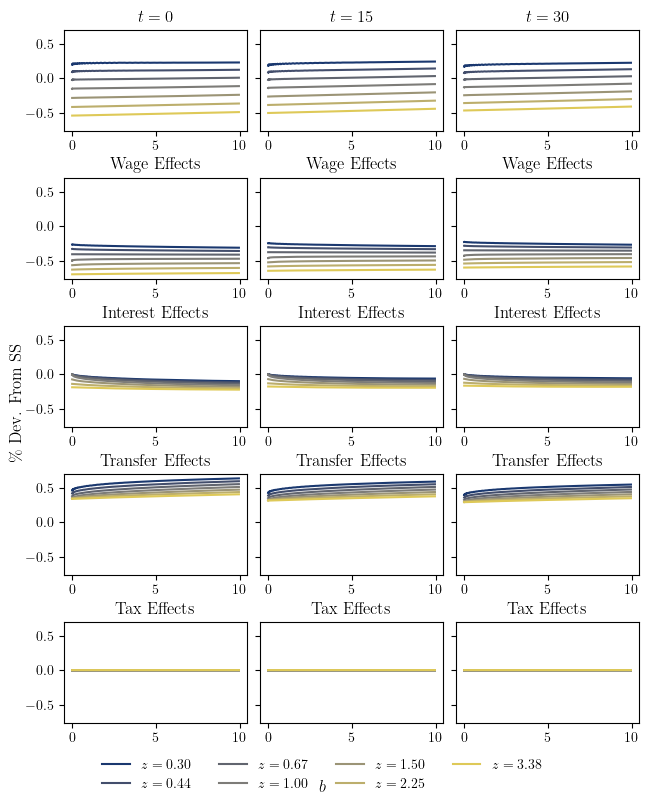

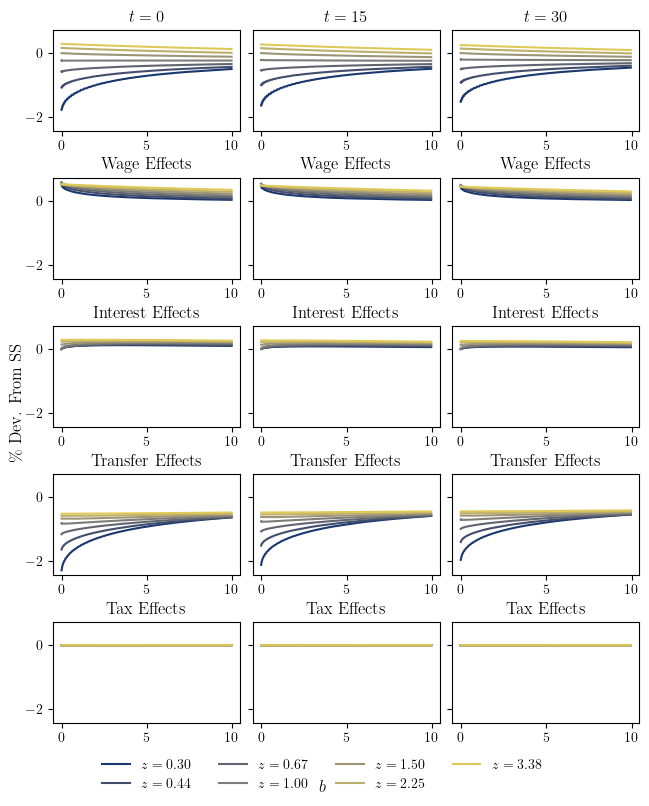

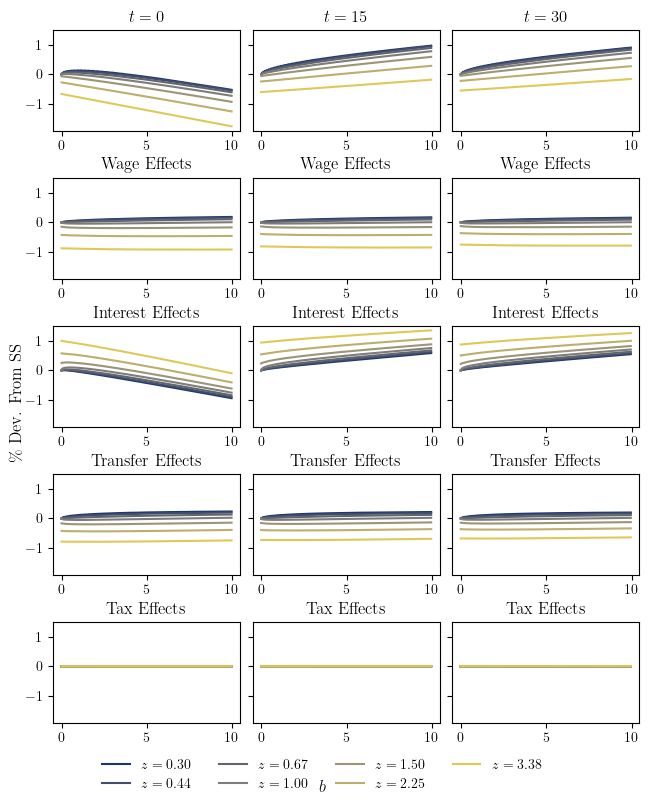

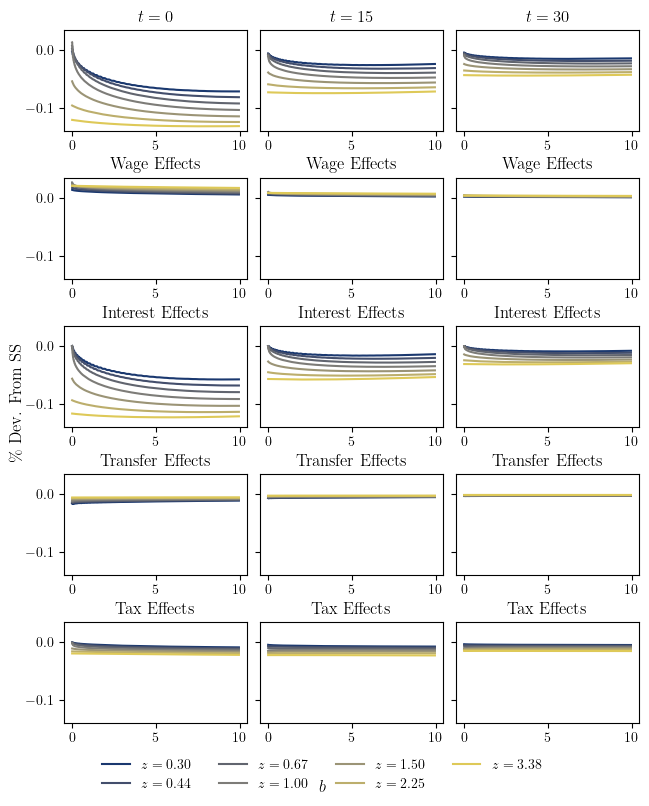

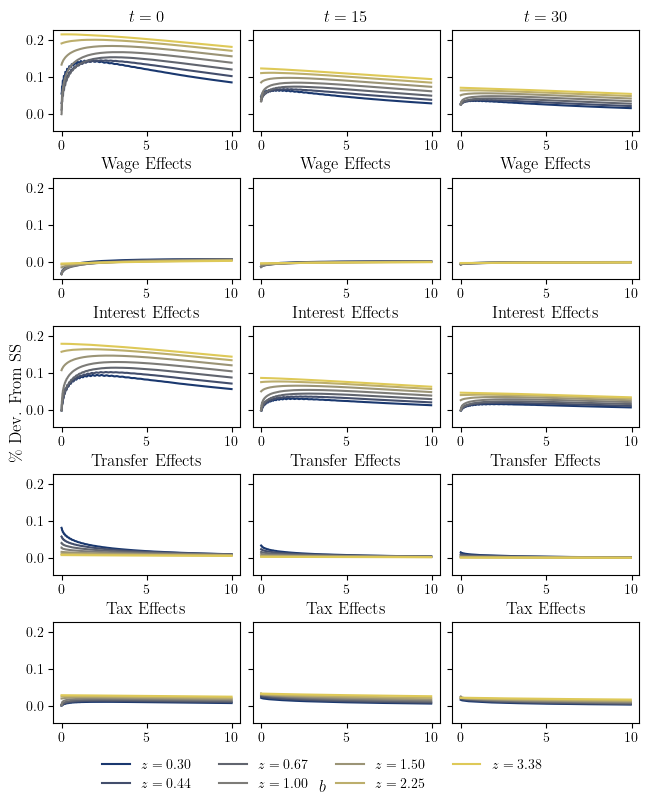

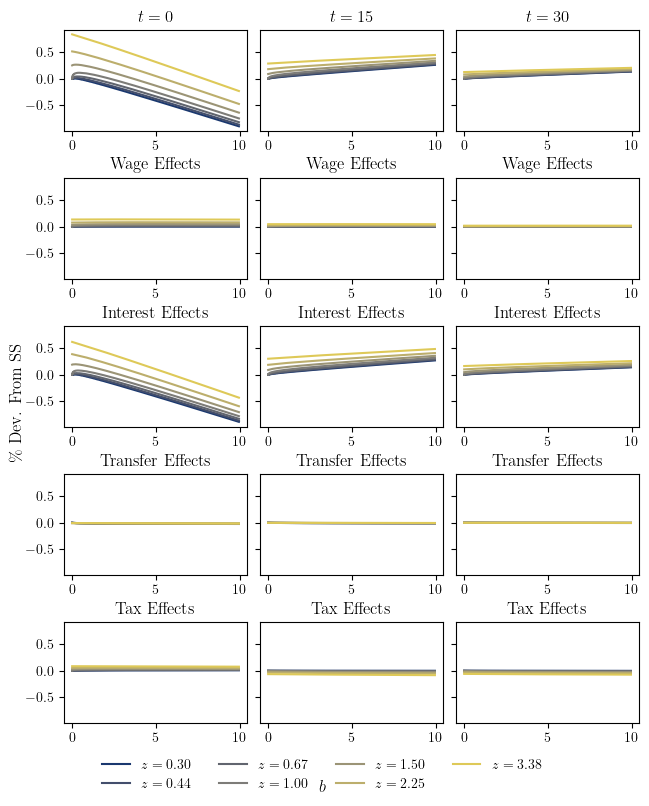

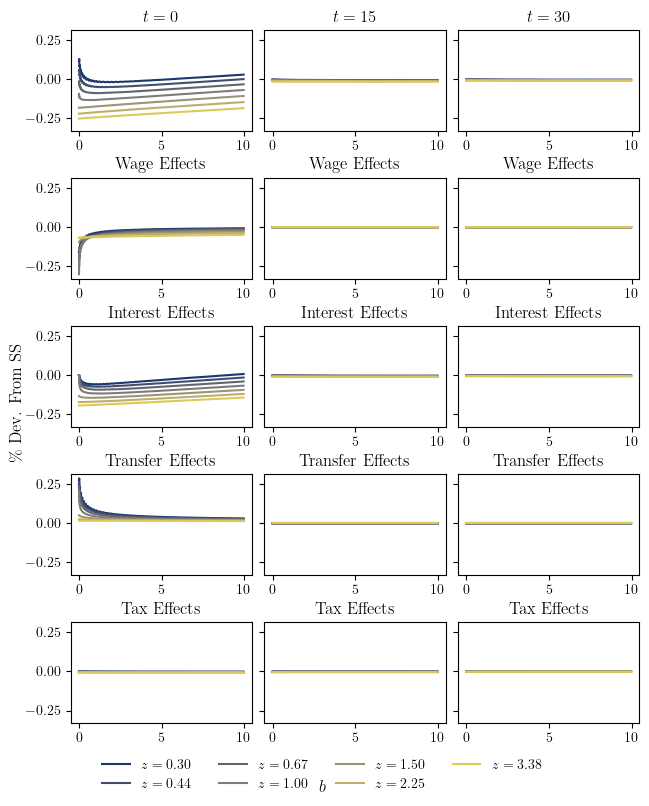

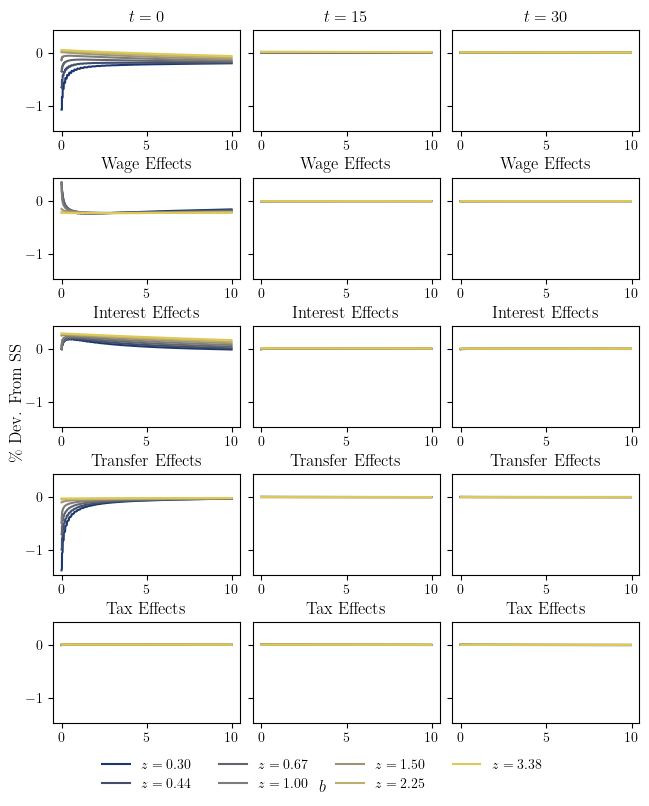

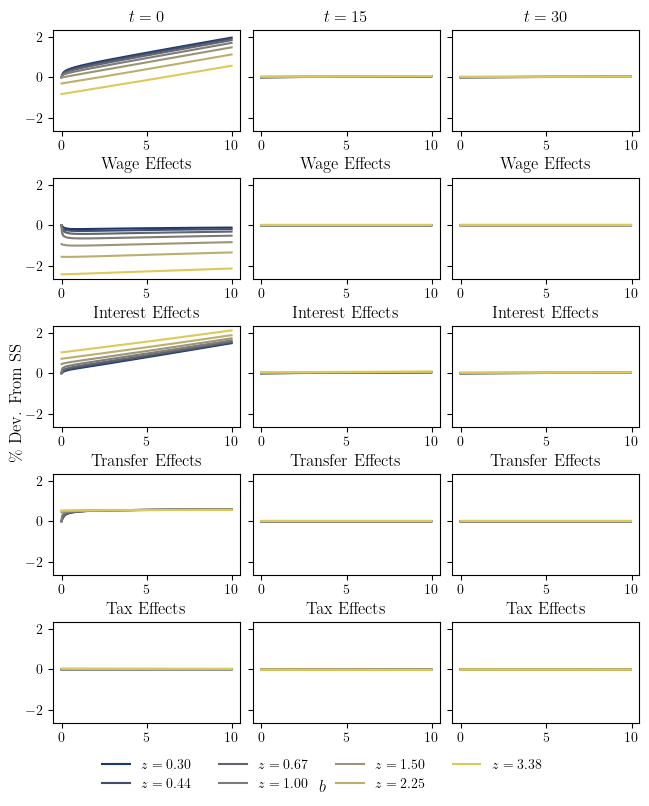

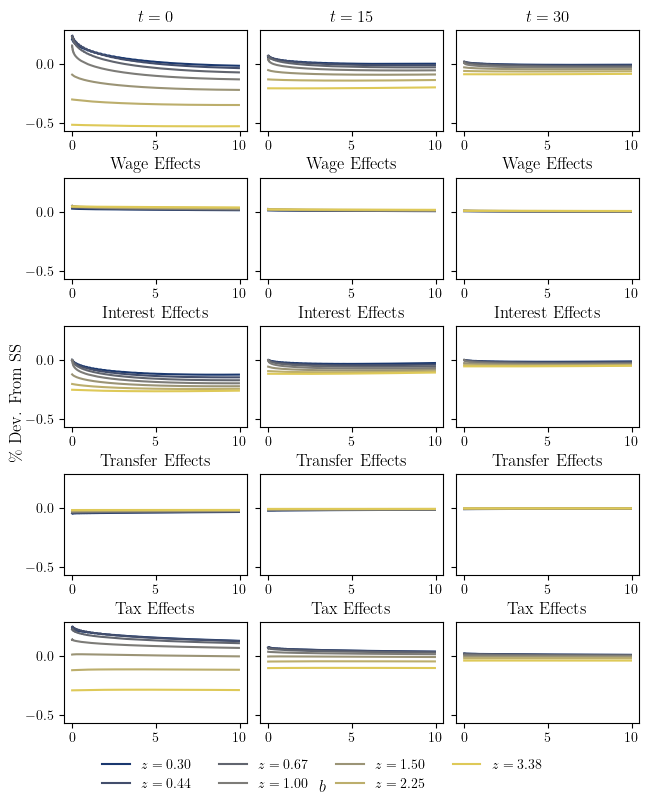

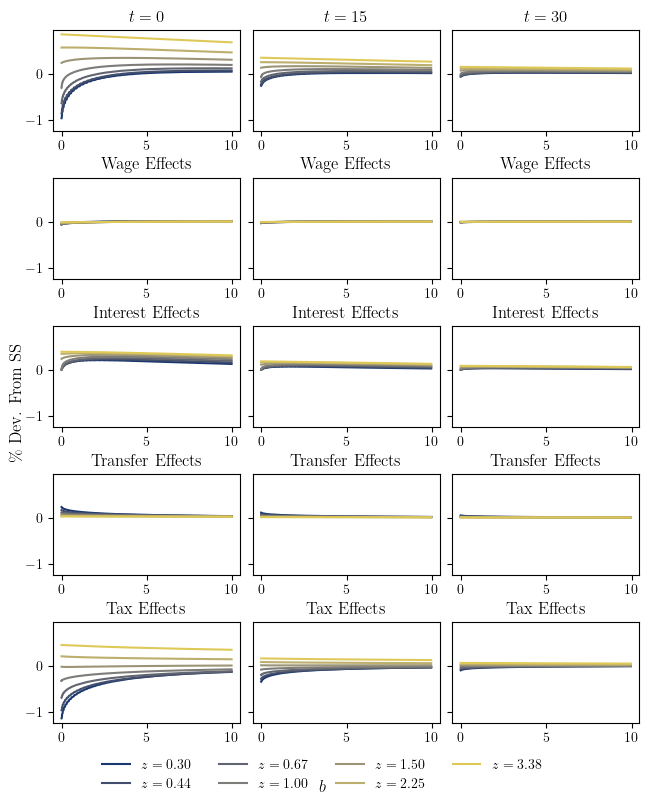

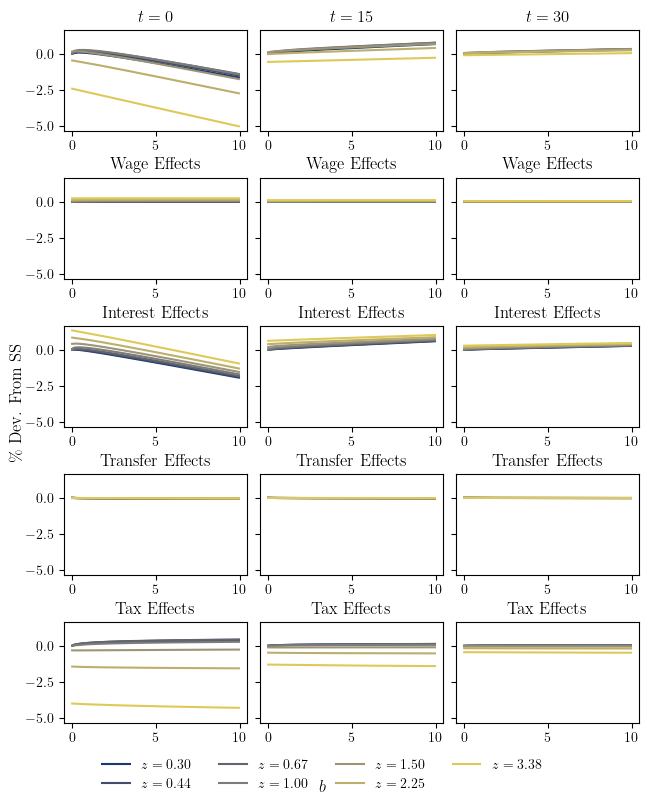

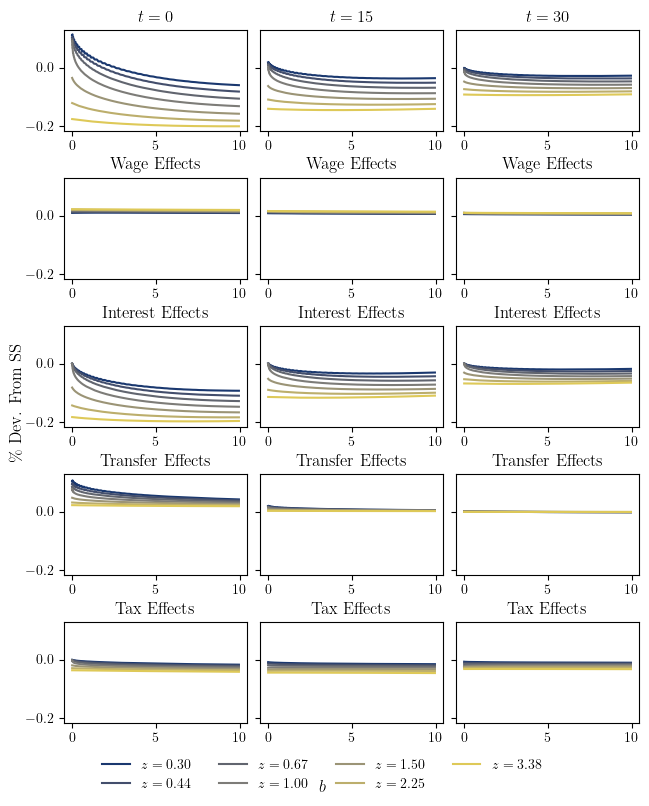

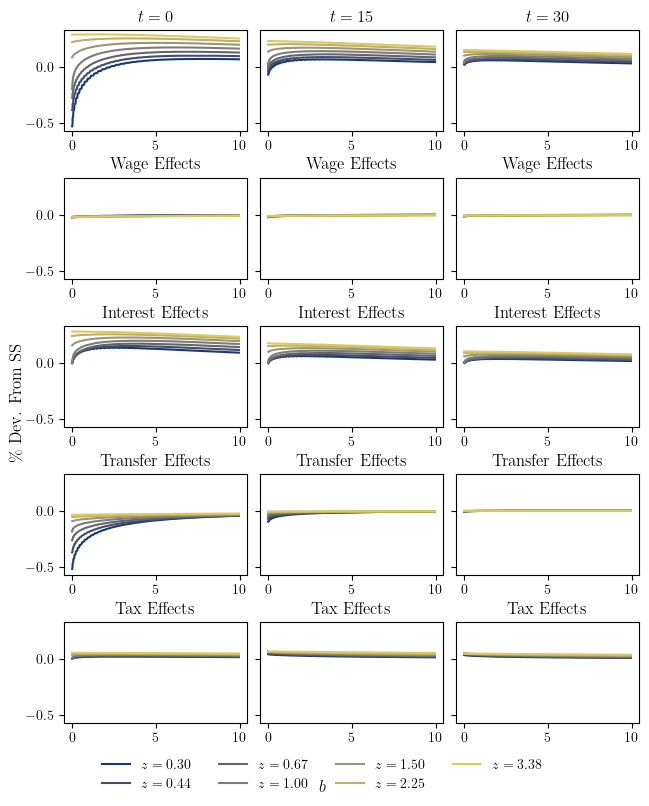

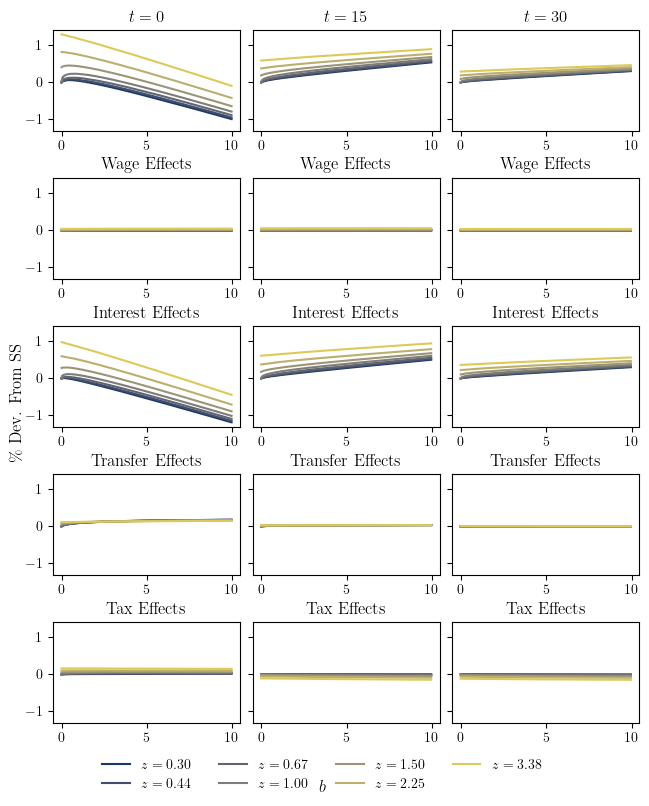

In [20]:
sns.set_palette(sns.color_palette('cividis', n_colors=7))

for Z in irf_decomp.keys():
    for x in ['c', 'l', 'a']:
        ## plot policy rule irfs
        fig, axs = plt.subplots(5, 3, sharey=True)
        fig.set_figheight(8)
        fig.set_figwidth(6.5)
        fig.supxlabel('$b$')
        fig.supylabel(r'\% Dev. From SS')
        n = (hank.a_grid < 10).sum()

        ## plot irf at t
        for i, t in enumerate([0, 15, 30]):
            # formating
            axs[0, i].set_title(f'$t = {t}$')

            # decomposition
            axs[1, i].set_title('Wage Effects')
            W_irf = irf_decomp[Z][x]['W'][t, :n]
            axs[1, i].plot(hank.a_grid[:n], W_irf)
            axs[2, i].set_title('Interest Effects')
            R_irf = irf_decomp[Z][x]['R'][t, :n]
            axs[2, i].plot(hank.a_grid[:n], R_irf)
            axs[3, i].set_title('Transfer Effects')
            T_irf = irf_decomp[Z][x]['D'][t, :n] + irf_decomp[Z][x].get('eta', np.zeros(T)[:, None])[t, :n]
            axs[3, i].plot(hank.a_grid[:n], T_irf)
            axs[4, i].set_title('Tax Effects')
            tau_irf = irf_decomp[Z][x]['tauL'][t, :n] + irf_decomp[Z][x].get('tauP', np.zeros(T)[:, None])[t, :n]
            axs[4, i].plot(hank.a_grid[:n], tau_irf)

            # whole thing
            lns = axs[0, i].plot(hank.a_grid[:n], W_irf + R_irf + T_irf + tau_irf, label=[f'$z = {z:.2f}$' for z in hank.z_grid])

        # fig.legend(handles=lns)
        fig.tight_layout(pad=0.5)
        fig.subplots_adjust(bottom=1/10)
        fig.legend(handles=lns, ncol=4, loc='lower center', bbox_to_anchor=(0.5, 0), frameon=False)
        # fig.savefig(f'paper/figures/{x}_{Z}_irf.pgf')